# Hierarchical Partial-Order (HPO) Model Simulation

This document provides a comprehensive guide to simulating data from a **Hierarchical Partial-Order (HPO) Model**. The HPO model is designed to generate hierarchical structures of partial orders based on latent variables influenced by multiple assessors. This simulation accounts for global latent scores, assessor-specific deviations, and observed ranking data within specified choice sets.

1: Global Latent U:U(0)∼N(0,Σ ρ​)
2: Assessor-Specific Latent Scores
3:Transformation to Preference Scores
4.Generation of Partial Orders for each η(a)

In [21]:
import numpy as np
import math
from scipy.stats import multivariate_normal, norm
import networkx as nx
import random
import seaborn as sns
import pandas as pd
from collections import Counter, defaultdict
import itertools
import matplotlib.pyplot as plt
from typing import List, Optional, Dict, Any
import sys as sys
import os 
from scipy.stats import beta

# Make sure these paths and imports match your local project structure
sys.path.append('../src/utils')  # Example path
from po_fun import BasicUtils, StatisticalUtils,GenerationUtils
from po_fun_plot import PO_plot 
from mallow_function import Mallows
from po_accelerator import LogLikelihoodCache,HPO_LogLikelihoodCache
sys.path.append('../src')  # Adjust the path if your directory structure is different
from hpo_po_hm_mcmc import mcmc_simulation_hpo
from typing import Dict, List

import yaml
with open("/home/doli/Desktop/research/coding/BayesianPartialOrders/hpo_mcmc_configuration.yaml", "r") as f:
    config = yaml.safe_load(f)

### U_0 and U_a priors construnction 
1. construct U_0 and U_a priors from the given prior 
2. given the h(U_0) and h(U_a) sampling the observed orders for each assessor

In [22]:
# First let's give a U0 , to sample U0 we need the rho, and the number of nodes
K=config["mcmc"]["K"]
rho_prior = config["prior"]["rho_prior"]
noise_option = config["noise"]["noise_option"]
# n is the number of total nodes to be considered 
n=8
rho_true=beta.rvs(1,rho_prior)
U_global = GenerationUtils.generate_U(n, K, rho_true)
print("U matrix (latent positions):")
print(U_global)
#tau_true = StatisticalUtils.rTauprior() 
tau_true=1 # this is the standard one which should give the same result as the one without hierachical structure 
print("Tau true is: ") 
print(tau_true)

U matrix (latent positions):
[[-1.01654397 -0.99889085 -1.01593906]
 [ 2.62252359  2.5998082   2.61487063]
 [ 1.51923025  1.53291746  1.51922094]
 [ 0.68051391  0.72050543  0.70889237]
 [-0.57042438 -0.61495421 -0.60768108]
 [-0.12770235 -0.11393019 -0.12500415]
 [-0.94428615 -0.94307338 -0.95479869]
 [ 1.01977132  1.02727829  1.01743312]]
Tau true is: 
1


In [23]:
#now we generate Ua 

assessors = [1, 2,3,4,5]
alpha = [0.5]*n
min_orders_per_assessor= n
# Generate selectino lists for each order
items = list(range(n))
item_to_index = {item: idx for idx, item in enumerate(items)}
index_to_item = {idx: item for idx, item in enumerate(items)}

M_a_list= GenerationUtils.generate_subsets(len(assessors), n) 

M_a_dict = {a: sorted(subset) for a, subset in zip(assessors, M_a_list)}

U_a_dict = {}  # We'll store U^(a) in a dictionary keyed by assessor ID

index_to_item_local_dict = {
    a: {i: item for i, item in enumerate(M_a_dict[a])}
    for a in assessors
}

for idx_a, a in enumerate(assessors):
    Ma = M_a_list[idx_a]
    n_a = len(Ma)
    Ua = np.zeros((n_a, K), dtype=float)

    # For each item j in M_a, sample from N(tau_true * U_global[j], (1 - tau_true^2)*I)
    for i_loc, j_global in enumerate(Ma):

        
        mean_vec = tau_true * U_global[j_global, :]
        cov_mat = (1.0 - tau_true**2) * rho_true * np.eye(K)
        Ua[i_loc, :] = np.random.multivariate_normal(mean=mean_vec, cov=cov_mat)

    U_a_dict[a] = Ua
print("\nGenerated U^(a) for each assessor:\n")
for idx_a, a in enumerate(assessors):
    print(f"Assessor {a} has shape {U_a_dict[a].shape}")
    print(U_a_dict[a])




Generated U^(a) for each assessor:

Assessor 1 has shape (4, 3)
[[-1.01654397 -0.99889085 -1.01593906]
 [ 2.62252359  2.5998082   2.61487063]
 [ 0.68051391  0.72050543  0.70889237]
 [-0.94428615 -0.94307338 -0.95479869]]
Assessor 2 has shape (7, 3)
[[-1.01654397 -0.99889085 -1.01593906]
 [ 2.62252359  2.5998082   2.61487063]
 [ 1.51923025  1.53291746  1.51922094]
 [ 0.68051391  0.72050543  0.70889237]
 [-0.57042438 -0.61495421 -0.60768108]
 [-0.12770235 -0.11393019 -0.12500415]
 [-0.94428615 -0.94307338 -0.95479869]]
Assessor 3 has shape (3, 3)
[[-1.01654397 -0.99889085 -1.01593906]
 [ 2.62252359  2.5998082   2.61487063]
 [-0.57042438 -0.61495421 -0.60768108]]
Assessor 4 has shape (7, 3)
[[-1.01654397 -0.99889085 -1.01593906]
 [ 2.62252359  2.5998082   2.61487063]
 [ 1.51923025  1.53291746  1.51922094]
 [ 0.68051391  0.72050543  0.70889237]
 [-0.57042438 -0.61495421 -0.60768108]
 [-0.12770235 -0.11393019 -0.12500415]
 [-0.94428615 -0.94307338 -0.95479869]]
Assessor 5 has shape (7, 3)


In [24]:
h_U_dict = StatisticalUtils.build_hierarchical_partial_orders(
    M0=items,
    assessors=assessors,
    M_a_dict=M_a_dict, 
    U0=U_global,
    U_a_dict=U_a_dict,
    alpha=alpha,
    link_inv=None
)
print("\nGenerated h_U for each assessor:\n")
for idx_a, a in enumerate(assessors):
    print(f"Assessor {a} has shape {h_U_dict[a].shape}")
    print(f"The item list of assessors are: {M_a_dict[a]}")
    print(h_U_dict[a])



Generated h_U for each assessor:

Assessor 1 has shape (4, 4)
The item list of assessors are: [0, 1, 3, 6]
[[0 0 0 0]
 [1 0 1 1]
 [1 0 0 1]
 [1 0 0 0]]
Assessor 2 has shape (7, 7)
The item list of assessors are: [0, 1, 2, 3, 4, 5, 6]
[[0 0 0 0 0 0 0]
 [1 0 1 1 1 1 1]
 [1 0 0 1 1 1 1]
 [1 0 0 0 1 1 1]
 [1 0 0 0 0 0 1]
 [1 0 0 0 1 0 1]
 [1 0 0 0 0 0 0]]
Assessor 3 has shape (3, 3)
The item list of assessors are: [0, 1, 4]
[[0 0 0]
 [1 0 1]
 [1 0 0]]
Assessor 4 has shape (7, 7)
The item list of assessors are: [0, 1, 2, 3, 4, 5, 6]
[[0 0 0 0 0 0 0]
 [1 0 1 1 1 1 1]
 [1 0 0 1 1 1 1]
 [1 0 0 0 1 1 1]
 [1 0 0 0 0 0 1]
 [1 0 0 0 1 0 1]
 [1 0 0 0 0 0 0]]
Assessor 5 has shape (7, 7)
The item list of assessors are: [0, 1, 2, 3, 4, 6, 7]
[[0 0 0 0 0 0 0]
 [1 0 1 1 1 1 1]
 [1 0 0 1 1 1 1]
 [1 0 0 0 1 1 0]
 [1 0 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [1 0 0 1 1 1 0]]


The global partial order matrix is:
[[0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]]


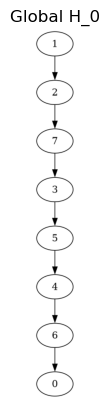

Assessor 1 has partial order matrix:
[0, 1, 3, 6]
[[0 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]]


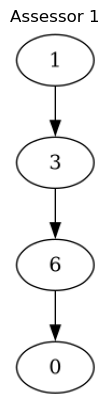

Assessor 2 has partial order matrix:
[0, 1, 2, 3, 4, 5, 6]
[[0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0]]


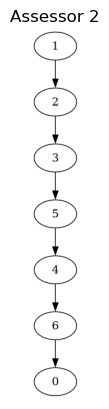

Assessor 3 has partial order matrix:
[0, 1, 4]
[[0 0 0]
 [0 0 1]
 [1 0 0]]


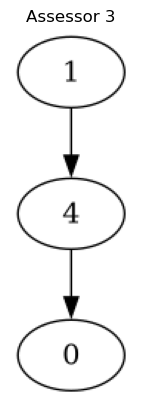

Assessor 4 has partial order matrix:
[0, 1, 2, 3, 4, 5, 6]
[[0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0]]


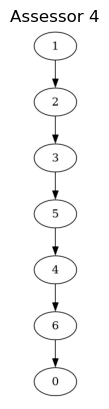

Assessor 5 has partial order matrix:
[0, 1, 2, 3, 4, 6, 7]
[[0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]


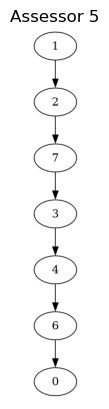

In [25]:
## Visualise the partial order matrix
for i in range(0,len(assessors)):
    if i==0:
        print(f"The global partial order matrix is:")
        print(BasicUtils.transitive_reduction(h_U_dict[0]))
        PO_plot.visualize_partial_order(BasicUtils.transitive_reduction(h_U_dict[0]), items ,f"Global H_0")

    print(f"Assessor {assessors[i]} has partial order matrix:")
    print(M_a_dict.get(assessors[i]))
    print(BasicUtils.transitive_reduction(h_U_dict.get(assessors[i])))
    PO_plot.visualize_partial_order(BasicUtils.transitive_reduction(h_U_dict.get(assessors[i])), M_a_dict.get(assessors[i]), f"Assessor {assessors[i]}")

### Below are the steps to generate the total orders from the generated partial orders 
1. We set a random variable to generate at least the number of orders for the observation, assume the number of ordes to generate is apossion distributino with the number of nodes in each of the MA list
3. We need to generate the subsets first, for each subset, there will be a order based on the given h_and the subset
4. however  there is a queque jump issue when generating the obderved order. 

In [26]:
O_a_i_dict = GenerationUtils.generate_choice_sets_for_assessors(M_a_dict, min_tasks=3, min_size=2)

# Print the result
for assessor, tasks in O_a_i_dict.items():
    print(f"Assessor {assessor}: {tasks}")

Assessor 1: [[0, 1, 3], [0, 1, 3, 6], [0, 1, 3], [0, 1, 3, 6], [1, 6], [0, 1], [1, 3, 6], [1, 3]]
Assessor 2: [[0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5], [0, 1, 5, 6], [0, 1, 2, 3], [1, 2, 3, 4, 5, 6], [1, 2, 5], [0, 1, 2, 3, 4, 5, 6], [1, 3, 4], [0, 6], [1, 5], [3, 5, 6], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 5, 6], [2, 3], [0, 2, 3], [0, 1, 2, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 6], [0, 1, 4], [0, 5], [0, 1, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6], [0, 1, 3, 4, 6], [0, 2], [0, 1, 2, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 5, 6], [0, 1, 2, 3, 4, 5, 6]]
Assessor 3: [[1, 4], [0, 1, 4], [0, 4], [1, 4], [0, 4], [1, 4]]
Assessor 4: [[0, 1, 2, 3, 6], [0, 2, 4, 5, 6], [0, 1, 3, 4, 5, 6], [0, 1, 3, 4, 6], [0, 1, 2, 3, 5], [0, 3, 4, 5, 6], [0, 1, 2], [0, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5], [0, 4, 6], [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 6], [0, 1, 2, 3, 4, 5, 6], [0, 2, 3, 5, 6], [0, 1, 2, 3, 4, 6], [0, 1, 2], [1, 2, 3, 6], [0, 1, 2, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6], [1

In [27]:
noise_beta_prior = config["prior"]["noise_beta_prior"] 
#prob_noise_true = StatisticalUtils.rPprior(noise_beta_prior)
prob_noise_true=0
print(prob_noise_true)

0


In [28]:
y_a_i_dict = GenerationUtils.generate_total_orders_for_assessor(h_U_dict, M_a_dict,O_a_i_dict,prob_noise_true)
print(y_a_i_dict)

{1: [[1, 3, 0], [1, 3, 6, 0], [1, 3, 0], [1, 3, 6, 0], [1, 6], [1, 0], [1, 3, 6], [1, 3]], 2: [[1, 2, 3, 5, 4, 6, 0], [1, 2, 3, 5, 4], [1, 5, 6, 0], [1, 2, 3, 0], [1, 2, 3, 5, 4, 6], [1, 2, 5], [1, 2, 3, 5, 4, 6, 0], [1, 3, 4], [6, 0], [1, 5], [3, 5, 6], [1, 2, 3, 5, 4, 0], [1, 2, 3, 5, 6, 0], [2, 3], [2, 3, 0], [1, 2, 5, 4, 6, 0], [1, 2, 3, 5, 4, 6, 0], [1, 2, 3, 4, 6, 0], [1, 4, 0], [5, 0], [1, 5, 4, 6, 0], [1, 2, 3, 5, 4, 6, 0], [1, 2, 3, 5, 4, 6], [1, 3, 4, 6, 0], [2, 0], [1, 2, 5, 4, 6, 0], [1, 2, 3, 5, 4, 6, 0], [1, 2, 3, 5, 6, 0], [1, 2, 3, 5, 4, 6, 0]], 3: [[1, 4], [1, 4, 0], [4, 0], [1, 4], [4, 0], [1, 4]], 4: [[1, 2, 3, 6, 0], [2, 5, 4, 6, 0], [1, 3, 5, 4, 6, 0], [1, 3, 4, 6, 0], [1, 2, 3, 5, 0], [3, 5, 4, 6, 0], [1, 2, 0], [2, 3, 5, 4, 6, 0], [1, 2, 3, 5, 4, 0], [4, 6, 0], [1, 2, 3, 5, 4, 6, 0], [1, 2, 3, 4, 6, 0], [1, 2, 3, 5, 4, 6, 0], [2, 3, 5, 6, 0], [1, 2, 3, 4, 6, 0], [1, 2, 0], [1, 2, 3, 6], [1, 2, 5, 4, 6, 0], [1, 2, 3, 5, 4, 6, 0], [1, 2, 5, 4]], 5: [[1, 2, 3, 4, 6,

# MCMC with Hierarchical Partial Orders  


1. Prior: \phi(\rho): \rho
2. Beta: \phi(\beta): \beta
3. Tau: \phi(\tau): \tau is betweeen 0 and 1 




In [29]:
M0=items
random_seed=42
assessors=assessors
M_a_dict=M_a_dict
O_a_i_dict=O_a_i_dict
U0=U_global
U_a_dict=U_a_dict
alpha=alpha
observed_orders=y_a_i_dict


num_iterations = config["mcmc"]["num_iterations"]
K = config["mcmc"]["K"]

mcmc_pt = [
    config["mcmc"]["update_probabilities"]["rho"],
    config["mcmc"]["update_probabilities"]["tau"],
    config["mcmc"]["update_probabilities"]["noise"],
    config["mcmc"]["update_probabilities"]["U_0"],
    config["mcmc"]["update_probabilities"]["U_a"]

    
]
rho_tau_update=config["reversible_two_factors"]["rho_tau_update"]


dr = config["rho"]["dr"]
drrt=config["rhotau"]["drrt"]


noise_option = config["noise"]["noise_option"]
sigma_mallow = config["noise"]["sigma_mallow"]

noise_beta_prior = config["prior"]["noise_beta_prior"]
mallow_ua = config["prior"]["mallow_ua"]



In [ ]:
mcmc_results = mcmc_simulation_hpo(
        num_iterations=10000,
        M0=M0,
        assessors=assessors,
        M_a_dict=M_a_dict,
        O_a_i_dict=O_a_i_dict,
        observed_orders=observed_orders,
        alpha=alpha,
        K=K,
        dr=dr,
        drrt=drrt,
        sigma_mallow=sigma_mallow,
        noise_option=noise_option,
        mcmc_pt=mcmc_pt,
        rho_prior=rho_prior,
        noise_beta_prior=noise_beta_prior,
        mallow_ua=mallow_ua,
        rho_tau_update=rho_tau_update,
        random_seed=42
)


Total number of samples in h_0: 100



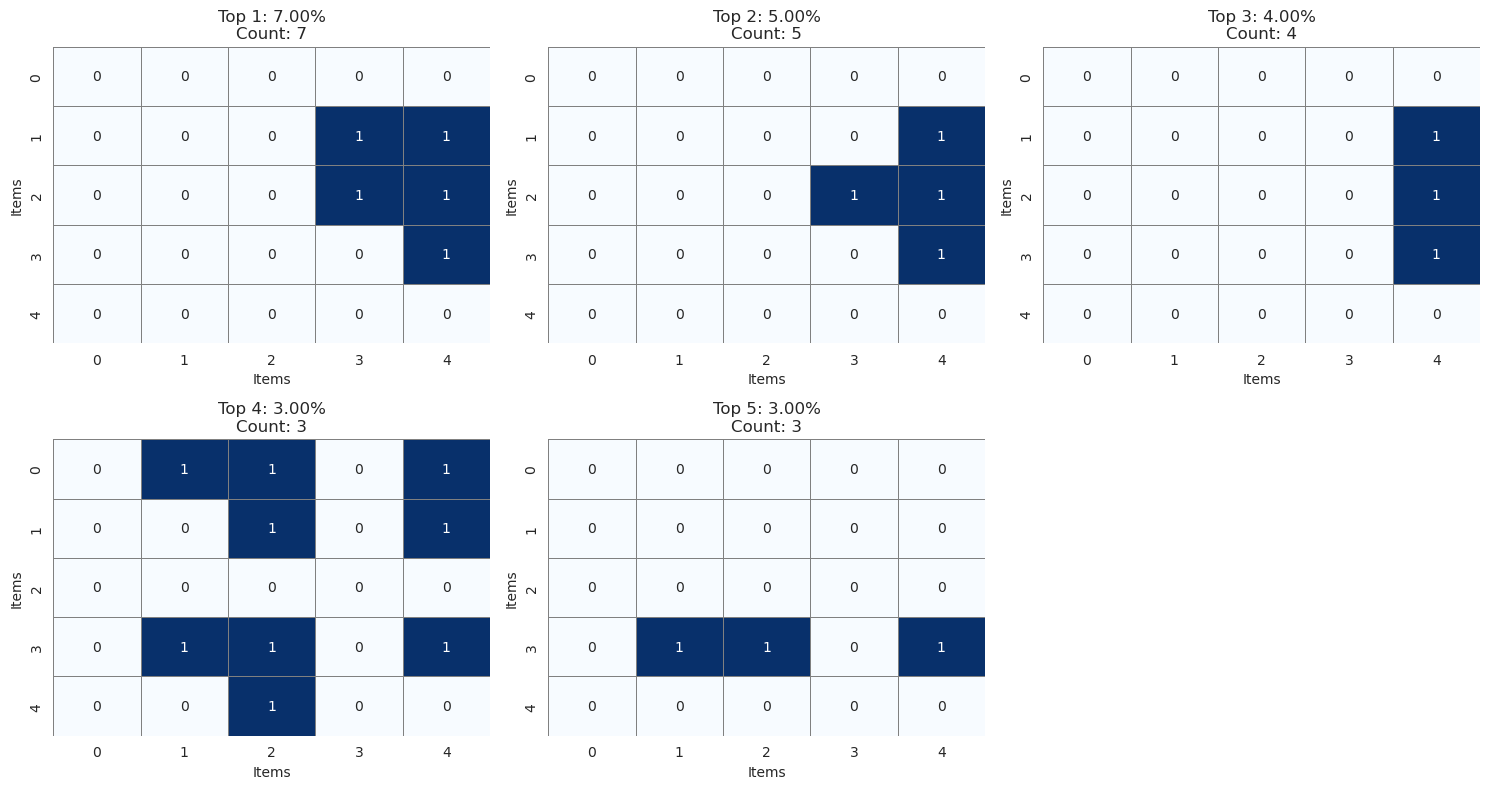

Total number of samples in h_1: 100



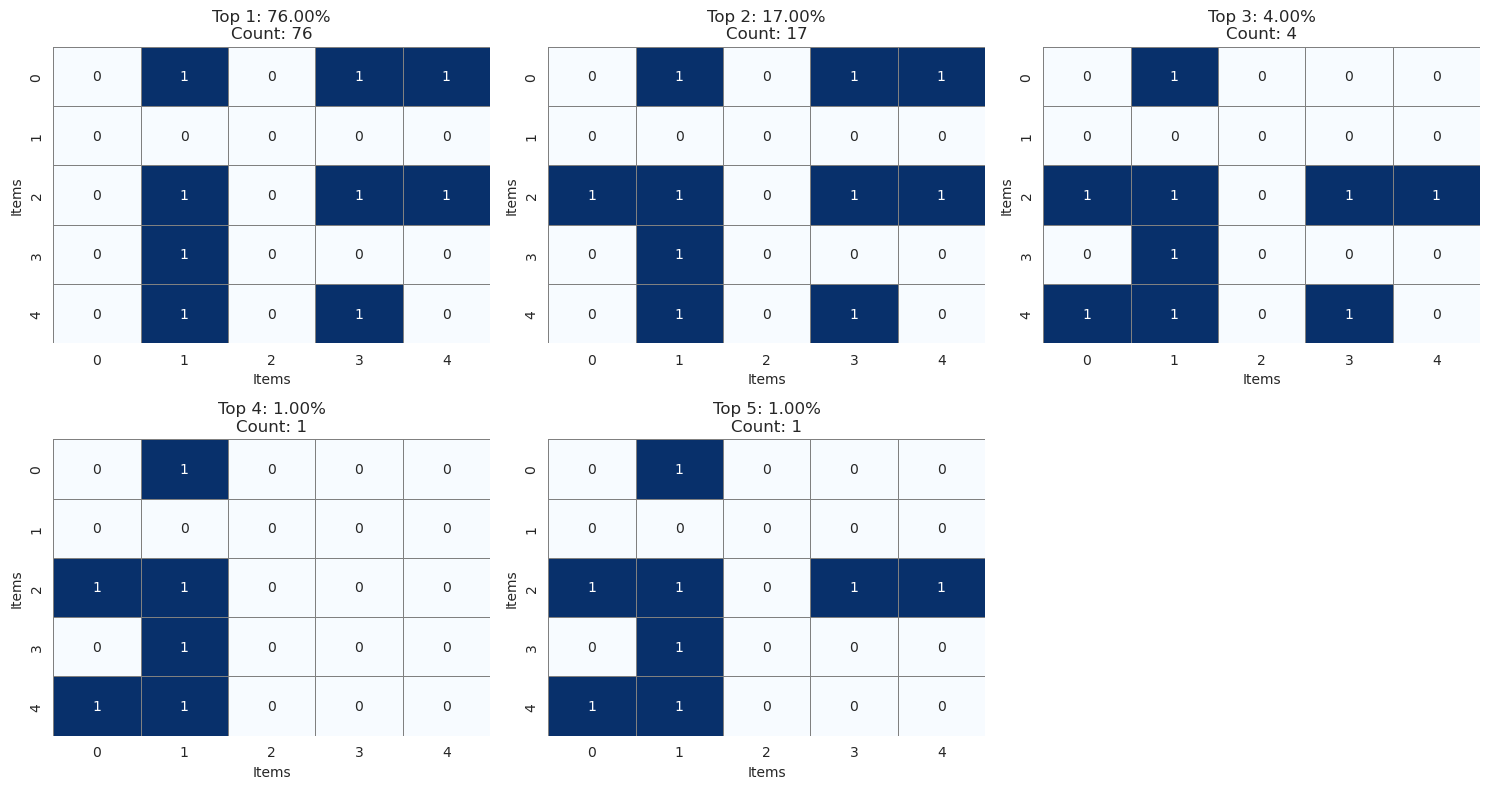

Total number of samples in h_2: 100



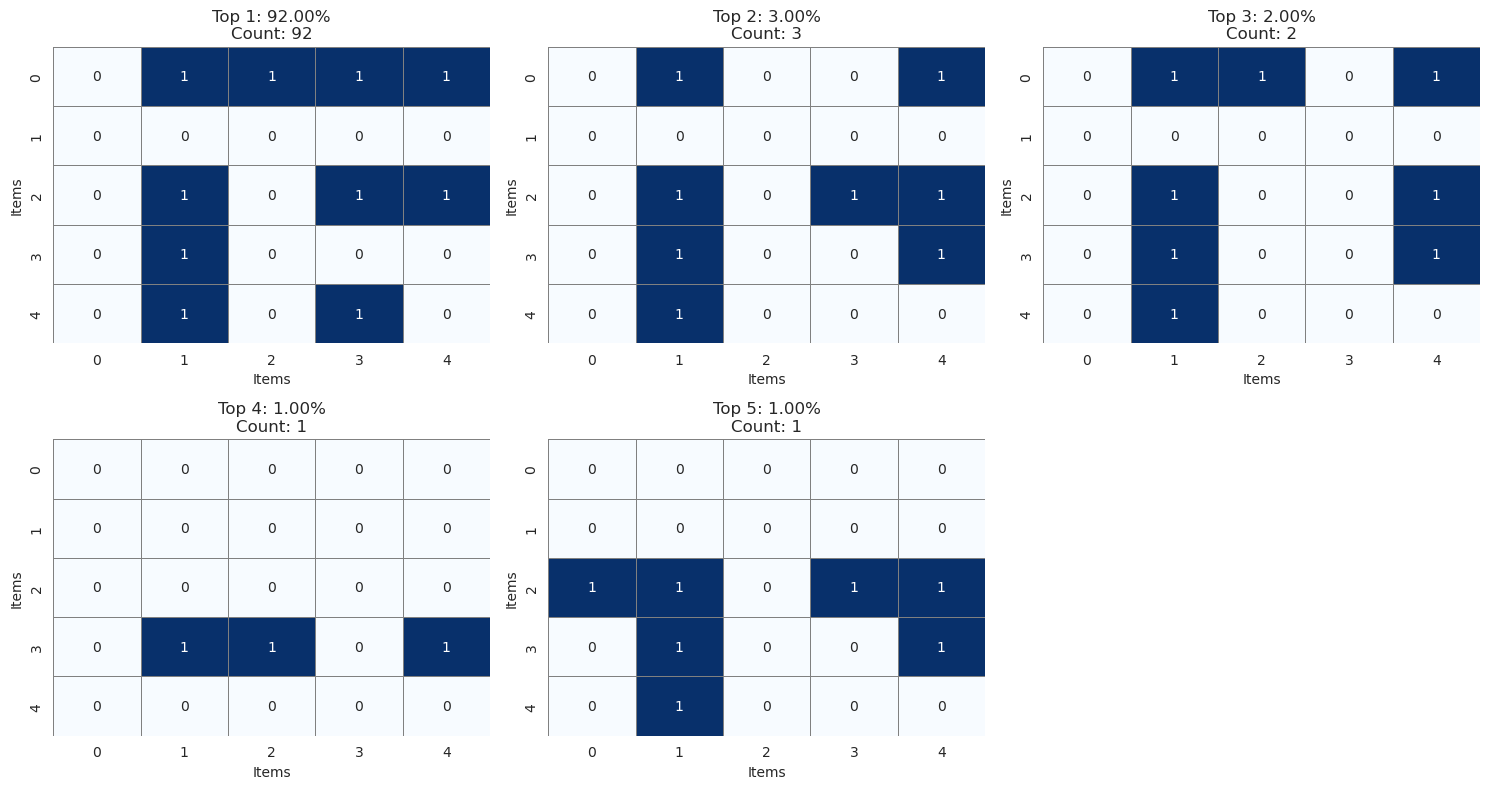

Total number of samples in h_3: 100



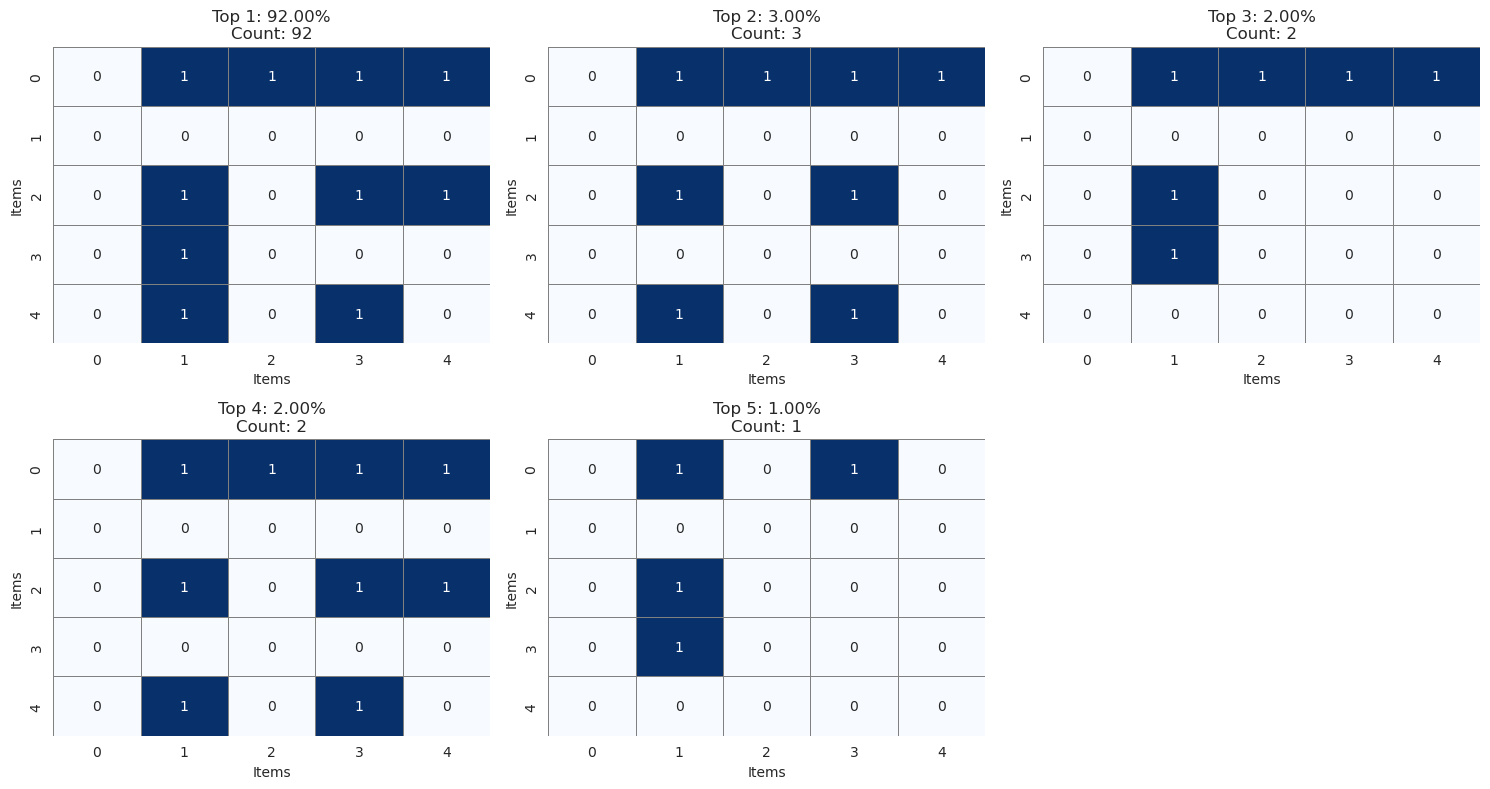

Total number of samples in h_4: 100



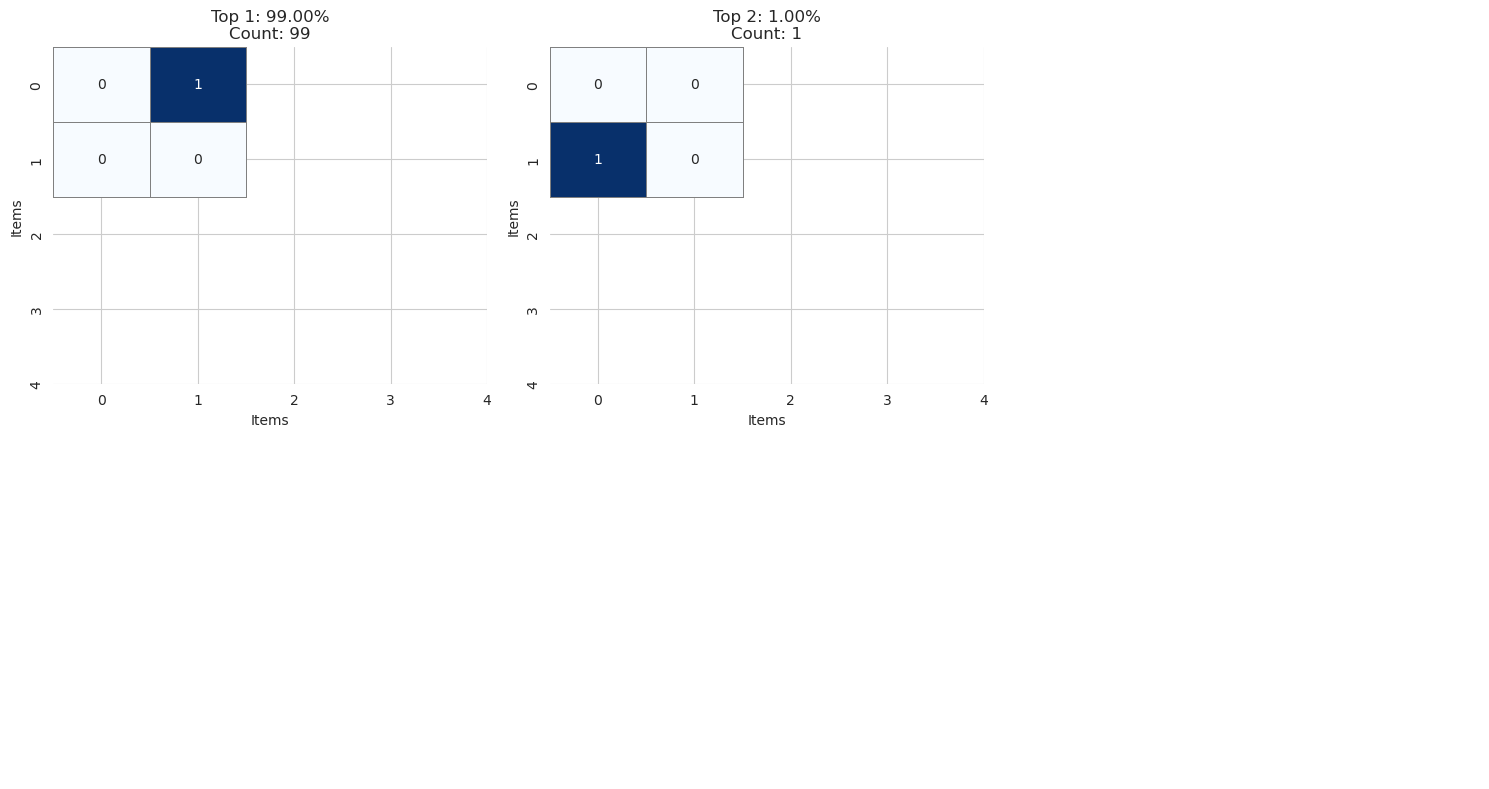

Total number of samples in h_5: 100



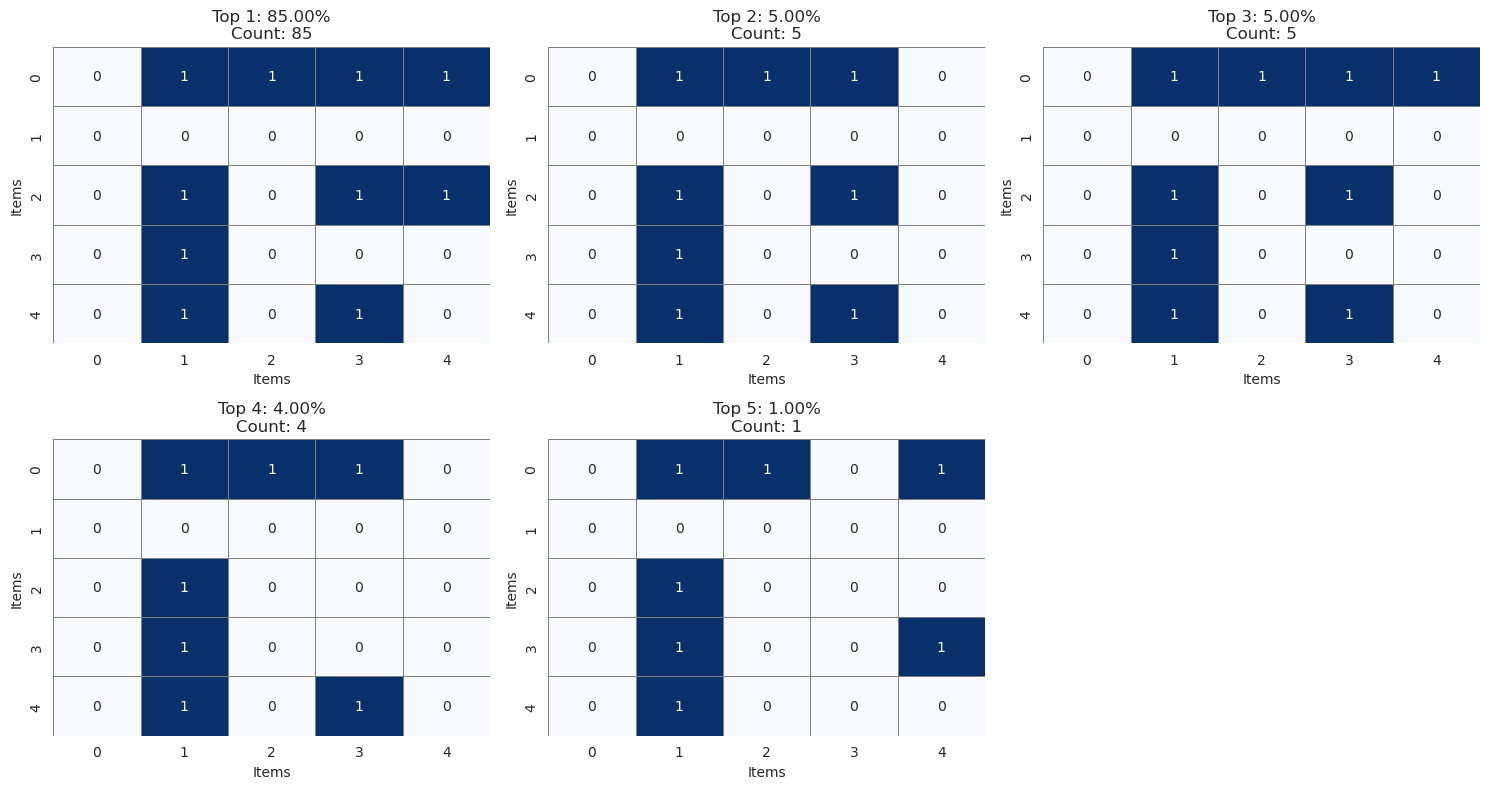

{0: array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]]), 1: array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0]]), 2: array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0]]), 3: array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0]]), 4: array([[0, 1],
       [0, 0]]), 5: array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0]])}


In [ ]:
h_trace= mcmc_results["H_trace"]

threshold = 0.5

# Create a new dictionary to store the final inferred binary partial orders.
final_H = {}
# Get all assessor IDs from the first iteration
assessor_ids = h_trace[0].keys()
for assessor in assessor_ids:
    # Collect the h matrix for this assessor from each iteration.
    matrices = [h_iter[assessor] for h_iter in h_trace if assessor in h_iter]
    # Compute element-wise average.
    mean_matrix = np.mean(matrices, axis=0)
    sorted_matrix= StatisticalUtils.count_unique_partial_orders(matrices)
    total_samples = sum(count for _, count in sorted_matrix)
    print(f"Total number of samples in h_{assessor}: {total_samples}\n")
    top_n = 5
    top_partial_orders =sorted_matrix[:top_n]
    top_percentages = [(order, count, (count / total_samples) * 100) for order, count in top_partial_orders]
    PO_plot.plot_top_partial_orders(top_percentages, top_n=top_n, item_labels=items)


    # Threshold the matrix.
    binary_matrix = (mean_matrix >= threshold).astype(int)
    # Compute transitive reduction.
    h_final = BasicUtils.transitive_reduction(binary_matrix)
    final_H[assessor] = h_final
print(final_H)

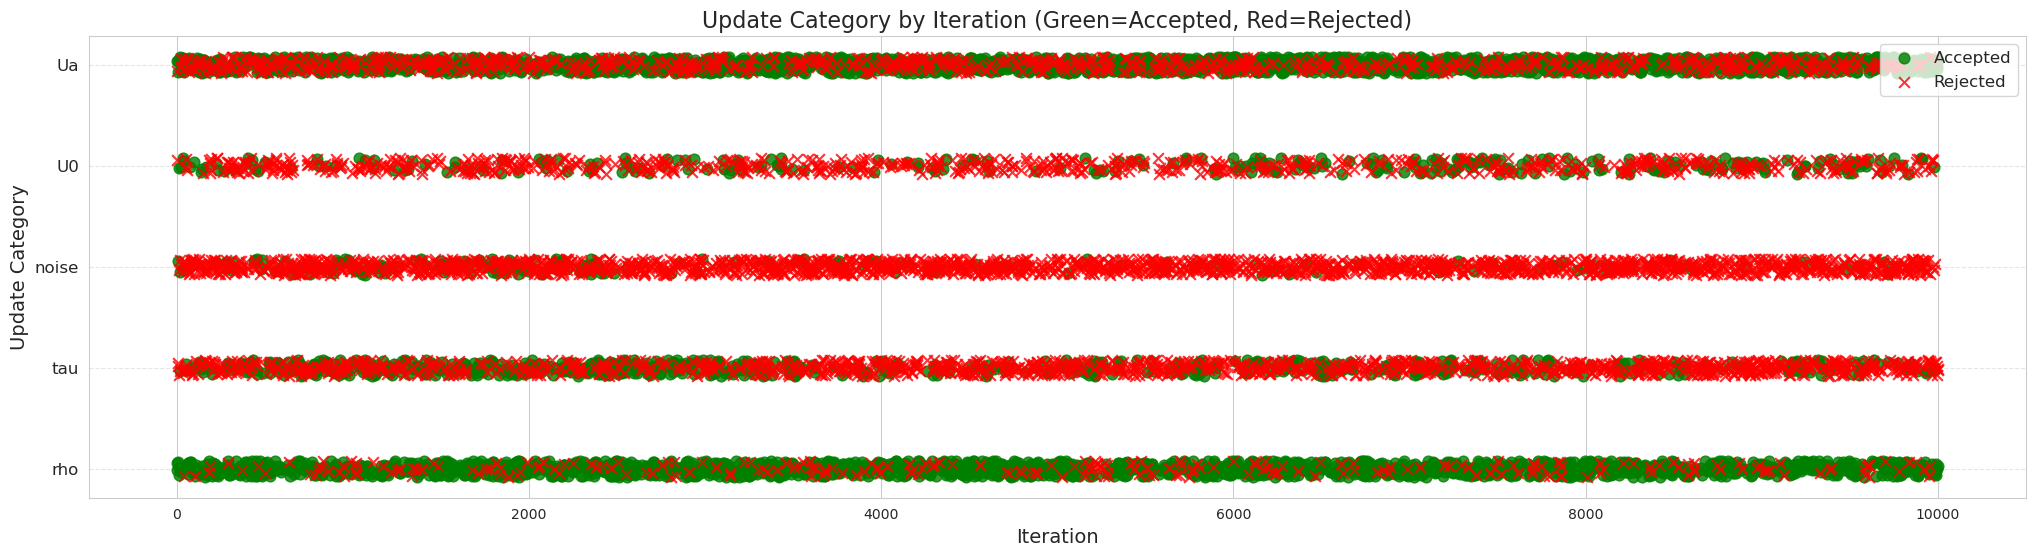

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

update_df = mcmc_results["update_df"]

# Mapping categories to labels
cat_label_map = {
    0: "rho",
    1: "tau",
    2: "noise",
    3: "U0",
    4: "Ua"
}
update_df["category_label"] = update_df["category"].map(cat_label_map)

# Unique categories
categories = sorted(update_df["category"].unique())

plt.figure(figsize=(25, 6))

# Jittering to spread points out slightly and avoid direct overlaps
jitter_strength = 0.08  # Control how much spread happens

# Iterate over categories to plot updates where they actually occurred
for category in categories:
    cat_data = update_df[update_df["category"] == category]
    
    if not cat_data.empty:
        y_jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(cat_data))
        y_values = cat_data["category"] + y_jitter  # Jittered y-axis for better separation

        # Accepted and Rejected updates
        accepted = cat_data[cat_data["accepted"]]
        rejected = cat_data[~cat_data["accepted"]]

        # Plot accepted updates (green circles)
        plt.scatter(accepted["iteration"], y_values[accepted.index], 
                    color="green", marker="o", s=60, alpha=0.8, label="Accepted" if category == 0 else "")

        # Plot rejected updates (red crosses)
        plt.scatter(rejected["iteration"], y_values[rejected.index], 
                    color="red", marker="x", s=60, alpha=0.8, label="Rejected" if category == 0 else "")

# Formatting: Y-axis labels, title, legend, grid
plt.yticks(ticks=categories, labels=[cat_label_map[c] for c in categories], fontsize=12)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Update Category", fontsize=14)
plt.title("Update Category by Iteration (Green=Accepted, Red=Rejected)", fontsize=16)
plt.legend(loc="upper right", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


In [ ]:
mallow_theta_true = 1/(1+mallow_ua)
true_param = {
    "rho_true": rho_true,
    "prob_noise_true": prob_noise_true,
    "mallow_theta_true": mallow_theta_true,
    "tau_true": tau_true,
}


[INFO] Saved MCMC parameter plots to 'mcmc_inferred_result.pdf'


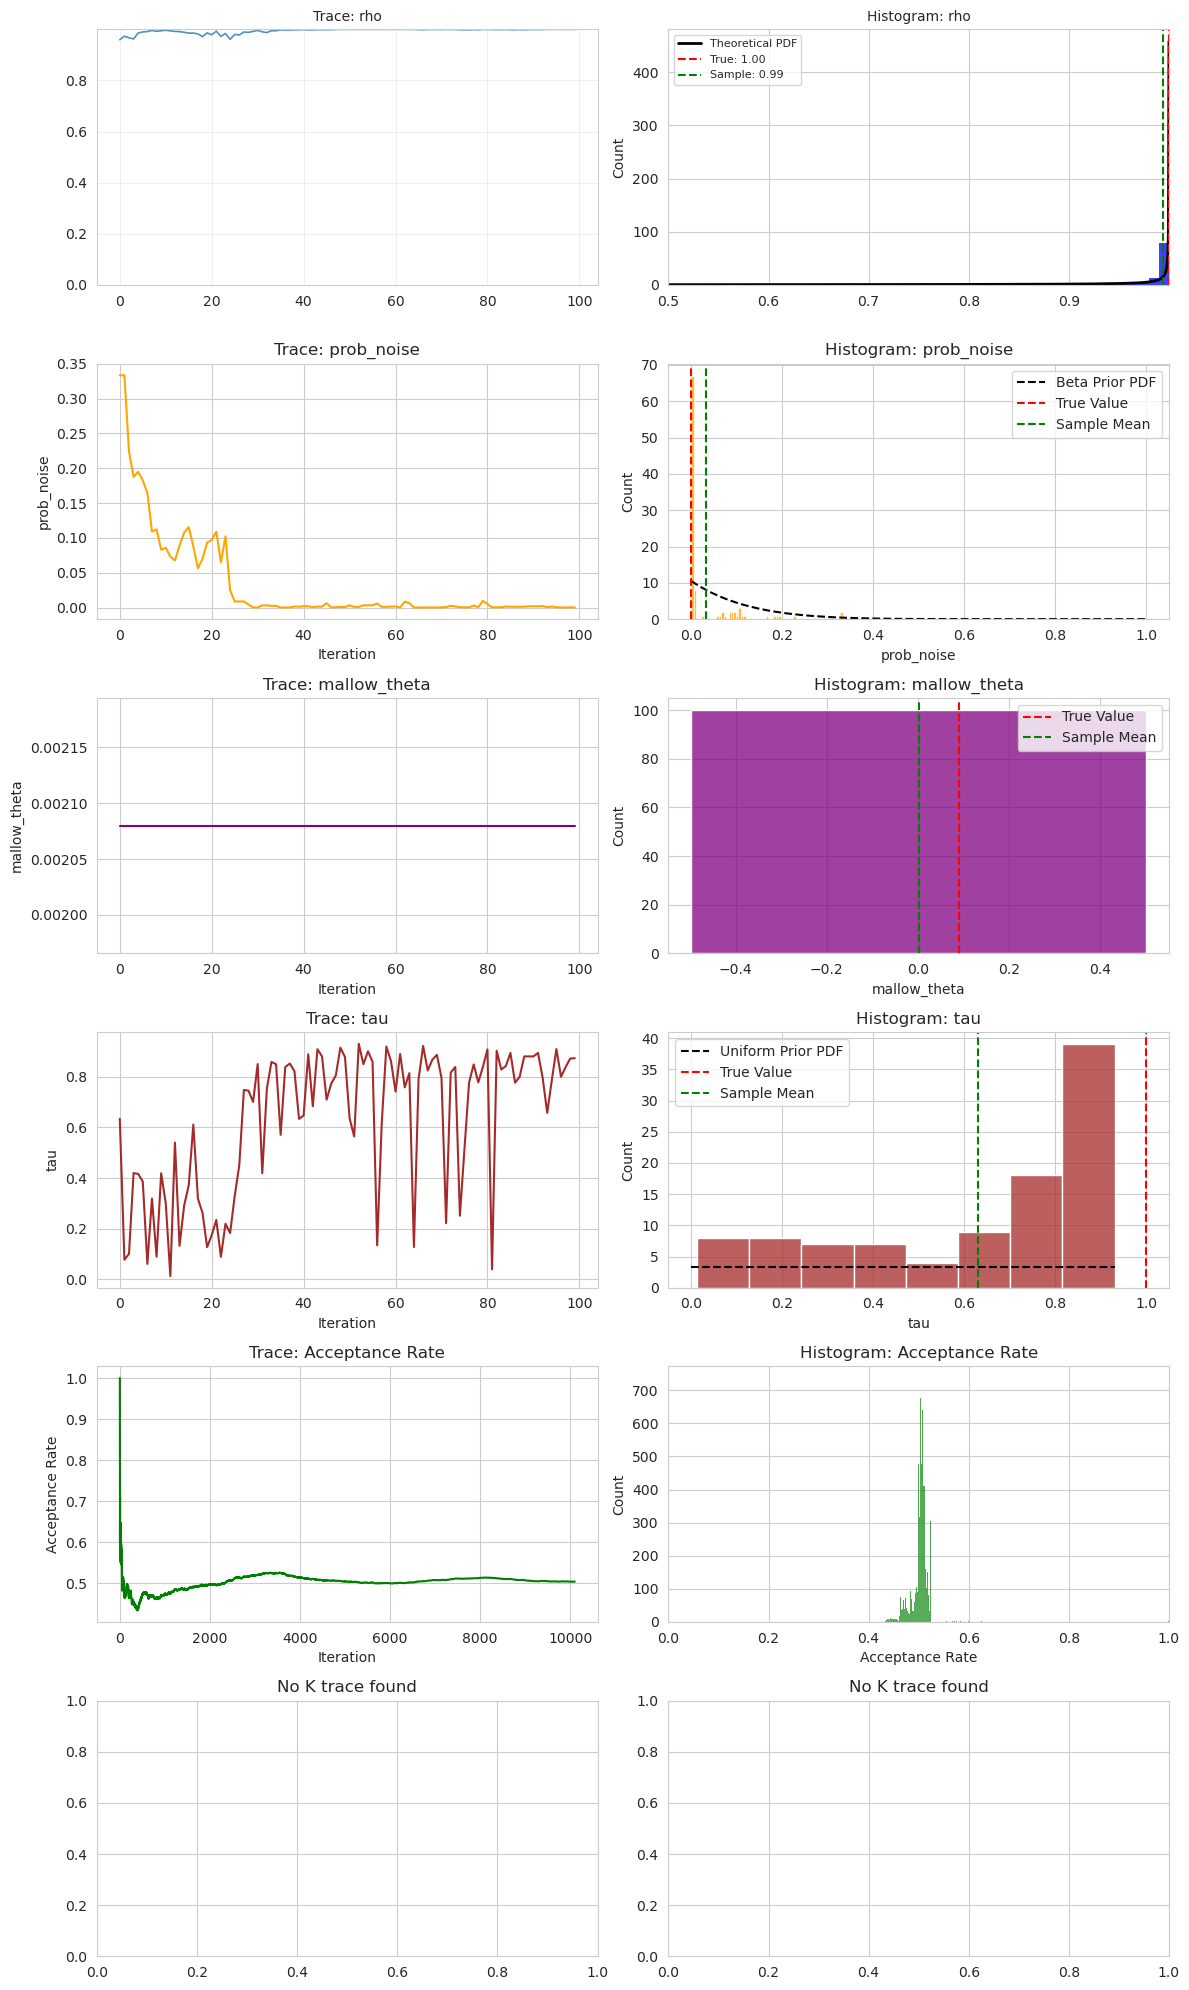

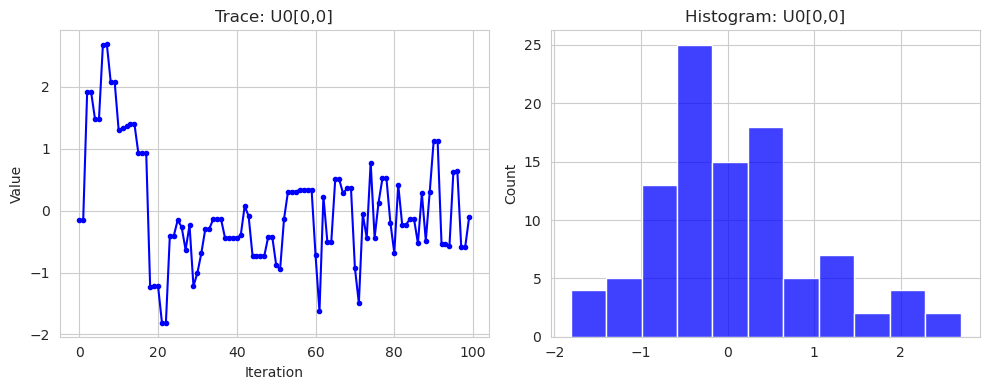

[INFO] Saved U0[0,0] trace & hist to 'U0_00_trace_hist.png'


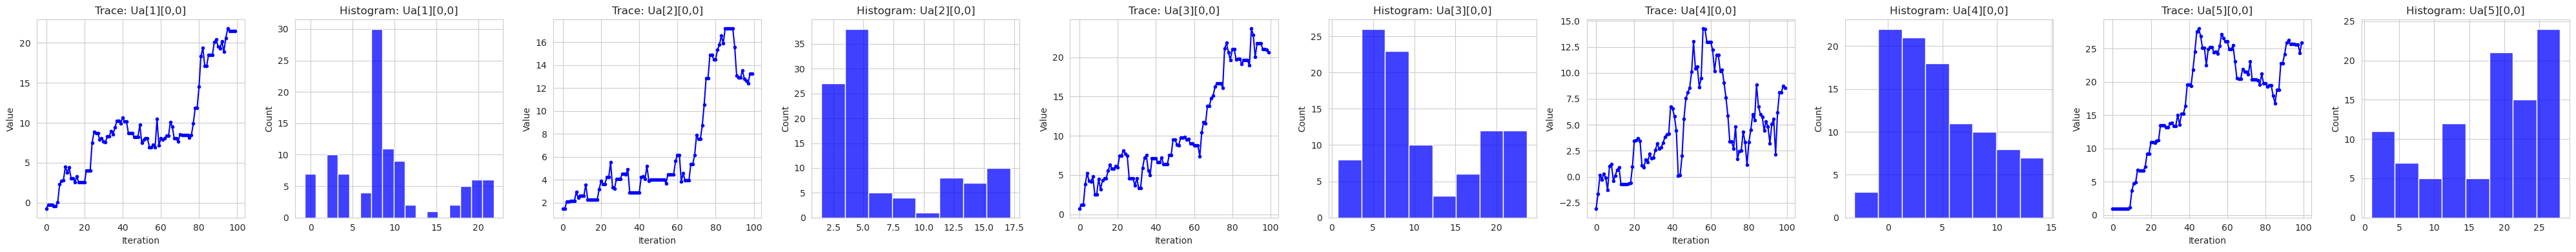

[INFO] Saved Ua[a][0,0] for each assessor to 'Ua_by_assessor_trace_hist.png'


In [ ]:
PO_plot.plot_mcmc_inferred_variables(
    mcmc_results,
    true_param,
    config,
    output_filename="mcmc_inferred_result.pdf",
    assessors=assessors,
    M_a_dict=M_a_dict  
)



## We compare the true result with the inferred result 

==== Compare & Visualize Global Partial Order ====


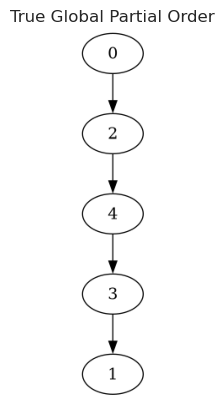

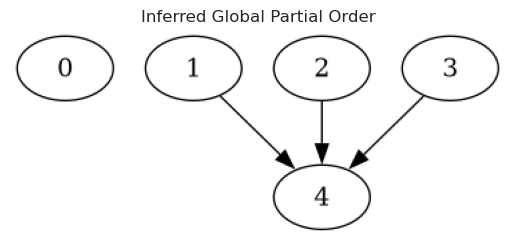


Missing (true PO edges not in inferred PO):
0 < 1
0 < 2
0 < 3
0 < 4
2 < 1
2 < 3
3 < 1
4 < 1
4 < 3

Redundant (inferred PO edges not in true PO):
1 < 4
3 < 4

==== Compare & Visualize Partial Order for Assessor 1 ====


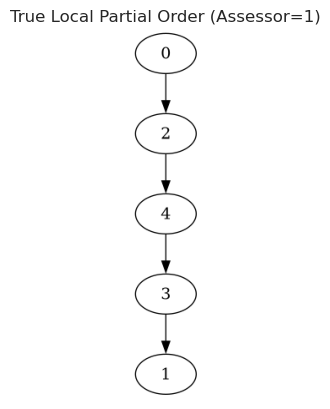

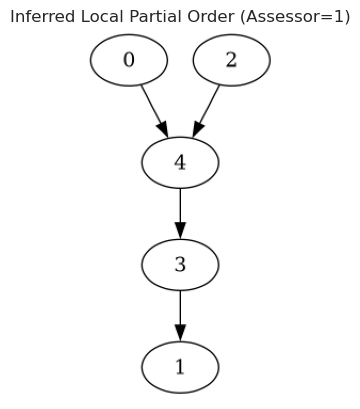


Missing edges for assessor 1:
0 < 1
0 < 2
0 < 3
2 < 1
2 < 3
4 < 1

No redundant edges for assessor 1.

==== Compare & Visualize Partial Order for Assessor 2 ====


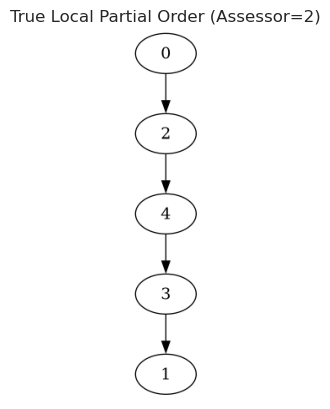

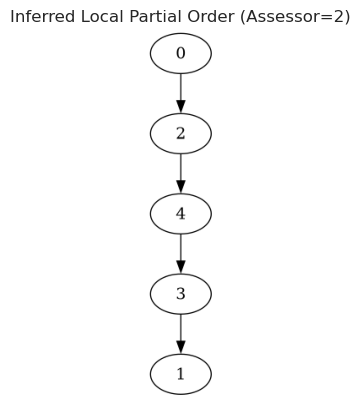


Missing edges for assessor 2:
0 < 1
0 < 3
0 < 4
2 < 1
2 < 3
4 < 1

No redundant edges for assessor 2.

==== Compare & Visualize Partial Order for Assessor 3 ====


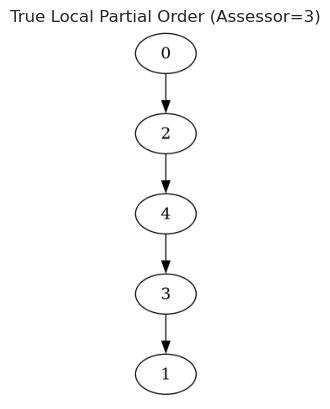

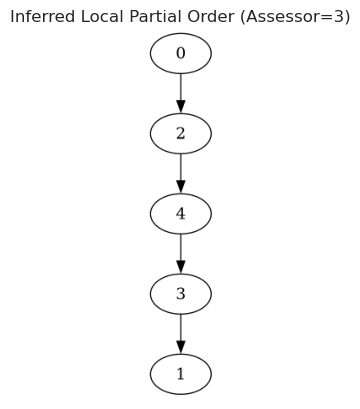


Missing edges for assessor 3:
0 < 1
0 < 3
0 < 4
2 < 1
2 < 3
4 < 1

No redundant edges for assessor 3.

==== Compare & Visualize Partial Order for Assessor 4 ====


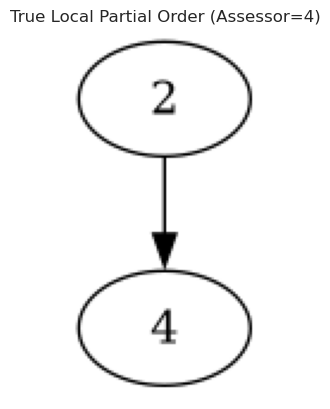

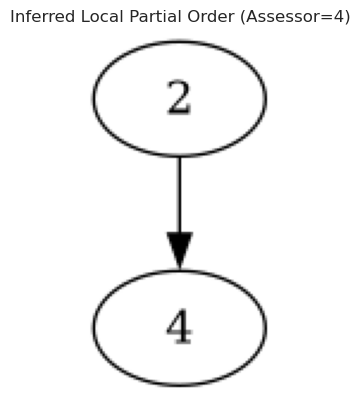


No missing edges for assessor 4.

No redundant edges for assessor 4.

==== Compare & Visualize Partial Order for Assessor 5 ====


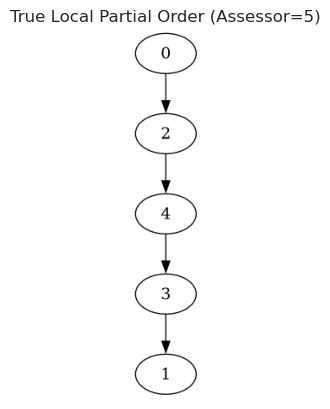

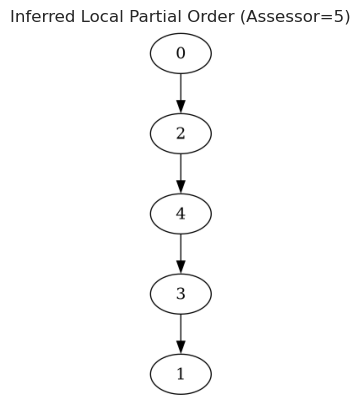


Missing edges for assessor 5:
0 < 1
0 < 3
0 < 4
2 < 1
2 < 3
4 < 1

No redundant edges for assessor 5.


In [ ]:
import numpy as np
from typing import List, Dict, Tuple

# Example: PO_plot and BasicUtils are assumed to be defined elsewhere.
# from your_code import PO_plot, BasicUtils

def compute_missing_relationships(
    h_true: np.ndarray,
    h_final: np.ndarray,
    index_to_item: Dict[int, int]
) -> List[Tuple[int, int]]:
    """
    Compute the missing relationships present in the true partial order but absent in the inferred one.

    Parameters
    ----------
    h_true : np.ndarray
        Adjacency matrix representing the true partial order.
    h_final : np.ndarray
        Adjacency matrix representing the inferred partial order.
    index_to_item : Dict[int, int]
        Mapping from matrix indices to items.

    Returns
    -------
    List[Tuple[int, int]]
        List of tuples (i, j) indicating missing relationships.
    """
    missing = []
    n = h_true.shape[0]
    for i in range(n):
        for j in range(n):
            if h_true[i, j] == 1 and h_final[i, j] == 0:
                missing.append((index_to_item[i], index_to_item[j]))
    return missing


def compute_redundant_relationships(
    h_true: np.ndarray,
    h_final: np.ndarray,
    index_to_item: Dict[int, int]
) -> List[Tuple[int, int]]:
    """
    Compute the redundant relationships present in the inferred partial order but absent in the true one.

    Parameters
    ----------
    h_true : np.ndarray
        Adjacency matrix representing the true partial order.
    h_final : np.ndarray
        Adjacency matrix representing the inferred partial order.
    index_to_item : Dict[int, int]
        Mapping from matrix indices to items.

    Returns
    -------
    List[Tuple[int, int]]
        List of tuples (i, j) indicating redundant relationships.
    """
    redundant = []
    n = h_true.shape[0]
    for i in range(n):
        for j in range(n):
            if h_true[i, j] == 0 and h_final[i, j] == 1:
                redundant.append((index_to_item[i], index_to_item[j]))
    return redundant


def compare_and_visualize_global(
    h_true_global: np.ndarray,
    h_inferred_global: np.ndarray,
    index_to_item_global: Dict[int, int],
    global_Ma_list: List[str],
    do_transitive_reduction: bool = True
) -> None:
    """
    Compare and visualize the global partial orders, printing any missing or redundant relationships.

    Parameters
    ----------
    h_true_global : np.ndarray
        Adjacency matrix for the true global partial order.
    h_inferred_global : np.ndarray
        Adjacency matrix for the inferred global partial order.
    index_to_item_global : Dict[int, int]
        Mapping from indices to items for the global order.
    global_Ma_list : List[str]
        Ordered list of global item labels.
    do_transitive_reduction : bool, optional
        Whether to apply transitive reduction for a cleaner plot (default is True).
    """
    # Optionally perform transitive reduction for visualization.
    if do_transitive_reduction:
        h_true_plot = BasicUtils.transitive_reduction(h_true_global)
        h_inferred_plot = BasicUtils.transitive_reduction(h_inferred_global)
    else:
        h_true_plot = h_true_global
        h_inferred_plot = h_inferred_global

    # Visualize the true and inferred global partial orders.
    PO_plot.visualize_partial_order(
        final_h=h_true_plot,
        Ma_list=global_Ma_list,
        title='True Global Partial Order'
    )
    PO_plot.visualize_partial_order(
        final_h=h_inferred_plot,
        Ma_list=global_Ma_list,
        title='Inferred Global Partial Order'
    )

    # Compute and print missing and redundant relationships.
    missing_relationships = compute_missing_relationships(h_true_global, h_inferred_global, index_to_item_global)
    redundant_relationships = compute_redundant_relationships(h_true_global, h_inferred_global, index_to_item_global)

    if missing_relationships:
        print("\nMissing (true PO edges not in inferred PO):")
        for i, j in missing_relationships:
            print(f"{i} < {j}")
    else:
        print("\nNo missing relationships in global partial order.")

    if redundant_relationships:
        print("\nRedundant (inferred PO edges not in true PO):")
        for i, j in redundant_relationships:
            print(f"{i} < {j}")
    else:
        print("\nNo redundant relationships in global partial order.")


def compare_and_visualize_assessor(
    assessor: int,
    Ma_list: List[str],
    h_true_a: np.ndarray,
    h_inferred_a: np.ndarray,
    index_to_item_local: Dict[int, int],
    do_transitive_reduction: bool = True
) -> None:
    """
    Compare and visualize the partial orders for a specific assessor, printing missing and redundant edges.

    Parameters
    ----------
    assessor : int
        The assessor's identifier.
    Ma_list : List[str]
        List of item labels for the assessor.
    h_true_a : np.ndarray
        True local partial order adjacency matrix for the assessor.
    h_inferred_a : np.ndarray
        Inferred local partial order adjacency matrix for the assessor.
    index_to_item_local : Dict[int, int]
        Mapping from local indices to items for the assessor.
    do_transitive_reduction : bool, optional
        Whether to apply transitive reduction (default is True).
    """
    if do_transitive_reduction:
        h_true_plot = BasicUtils.transitive_reduction(h_true_a)
        h_inferred_plot = BasicUtils.transitive_reduction(h_inferred_a)
    else:
        h_true_plot = h_true_a
        h_inferred_plot = h_inferred_a

    # Visualize local partial orders for the assessor.
    PO_plot.visualize_partial_order(
        final_h=h_true_plot,
        Ma_list=Ma_list,
        title=f"True Local Partial Order (Assessor={assessor})"
    )
    PO_plot.visualize_partial_order(
        final_h=h_inferred_plot,
        Ma_list=Ma_list,
        title=f"Inferred Local Partial Order (Assessor={assessor})"
    )

    # Compute and print missing and redundant relationships.
    missing_relationships = compute_missing_relationships(h_true_a, h_inferred_a, index_to_item_local)
    redundant_relationships = compute_redundant_relationships(h_true_a, h_inferred_a, index_to_item_local)

    if missing_relationships:
        print(f"\nMissing edges for assessor {assessor}:")
        for i, j in missing_relationships:
            print(f"{i} < {j}")
    else:
        print(f"\nNo missing edges for assessor {assessor}.")

    if redundant_relationships:
        print(f"\nRedundant edges for assessor {assessor}:")
        for i, j in redundant_relationships:
            print(f"{i} < {j}")
    else:
        print(f"\nNo redundant edges for assessor {assessor}.")


def main_check_all(
    h_true_global: np.ndarray,
    h_inferred_global: np.ndarray,
    index_to_item_global: Dict[int, int],
    h_true_a_dict: Dict[int, np.ndarray],
    h_inferred_a_dict: Dict[int, np.ndarray],
    index_to_item_local_dict: Dict[int, Dict[int, int]],
    M_a_dict: Dict[int, List[str]],
    assessors: List[int]
) -> None:
    """
    High-level function that compares and visualizes both the global partial order and each assessor's local partial order.

    Parameters
    ----------
    h_true_global : np.ndarray
        Global true partial order adjacency matrix.
    h_inferred_global : np.ndarray
        Global inferred partial order adjacency matrix.
    index_to_item_global : Dict[int, int]
        Mapping from global indices to items.
    h_true_a_dict : Dict[int, np.ndarray]
        Dictionary mapping assessor IDs to their true local adjacency matrices.
    h_inferred_a_dict : Dict[int, np.ndarray]
        Dictionary mapping assessor IDs to their inferred local adjacency matrices.
    index_to_item_local_dict : Dict[int, Dict[int, int]]
        Dictionary mapping assessor IDs to their local index-to-item mappings.
    M_a_dict : Dict[int, List[str]]
        Dictionary mapping assessor IDs to their list of item labels.
    assessors : List[int]
        List of assessor identifiers.
    """
    print("==== Compare & Visualize Global Partial Order ====")
    # Construct a sorted list of global item labels.
    global_Ma_list = [index_to_item_global[i] for i in sorted(index_to_item_global.keys())]

    compare_and_visualize_global(
        h_true_global,
        h_inferred_global,
        index_to_item_global,
        global_Ma_list,
        do_transitive_reduction=True
    )

    for assessor in assessors:
        print(f"\n==== Compare & Visualize Partial Order for Assessor {assessor} ====")
        Ma_list_for_a = M_a_dict.get(assessor)
        compare_and_visualize_assessor(
            assessor,
            Ma_list_for_a,
            h_true_a_dict[assessor],
            h_inferred_a_dict[assessor],
            index_to_item_local_dict[assessor],
            do_transitive_reduction=True
        )


if __name__ == "__main__":
    # Example variable definitions (assumed to be provided elsewhere)
    # h_U_dict: Dict[int, np.ndarray]  -> true adjacency matrices, with key 0 for global
    # final_H: Dict[int, np.ndarray]   -> inferred adjacency matrices, with key 0 for global
    # M_a_dict: Dict[int, List[str]]   -> assessor-specific item labels
    # assessors: List[int]             -> list of assessor IDs
    # index_to_item: Dict[int, int]    -> global index to item mapping
    # index_to_item_local_dict: Dict[int, Dict[int, int]] -> local index to item mapping for each assessor

    # Global partial order matrices.
    h_true_global = h_U_dict[0]
    h_inferred_global = final_H[0]

    # Build dictionaries for each assessor's adjacency matrices.
    h_true_a_dict = {a: h_U_dict.get(a) for a in assessors}
    h_inferred_a_dict = {a: final_H.get(a) for a in assessors}

    main_check_all(
        h_true_global,
        h_inferred_global,
        index_to_item,
        h_true_a_dict,
        h_inferred_a_dict,
        index_to_item_local_dict,
        M_a_dict,
        assessors
    )
